---

# Modelling Cascades in Cyber Systems

---

## Recruiter Notebook 1: Self-Organised Criticality in a Toy SOC System

This is **recruiter summary** of *Notebook 1: An Introduction to Self-Organising, Critical Systems: Cascades, Criticality and Why They Matter*, an exploratory project on **self-organised criticality (SOC)**.  

The goal is not to present a production-ready SOC tool, but to demonstrate how I:

- translate a complex systems concept into an **implementable simulation**
- generate **analysis-ready data** (not just visuals)
- extract and validate **hallmark SOC signatures** (heavy tails, burstiness, punctuated activity)
- use the toy system as an **intuitive stepping stone** before moving to **network structures** (more directly relevant to SOC environments)

> **Scope note:** This is a toy model used for conceptual grounding. I avoid claims of direct operational mapping to real SOC infrastructure.

---


## The Drossel–Schwabl forest-fire model as an intuition-building starting point

SOC environments often face **rare, high-impact cascades** driven by local interactions that amplify across a system. Before introducing network structures, I started with a canonical SOC model where:

- the rules are simple and fully inspectable
- the emergent behaviour is non-trivial
- the event stream can be analysed with the same habits used for security telemetry (distributional shape, burstiness, regime shifts)

The **Drossel–Schwabl forest-fire model** is a well-known example: local growth and ignition rules generate **avalanches** of varying size, often producing **scale-free** event statistics under broad conditions.

---


## Implementation summary

The repository includes a Python program `soc_forest_v10.py` that:

- simulates the Drossel–Schwabl forest-fire dynamics on a grid
- logs event-level data so that emergent properties can be analysed quantitatively
- optionally produces a live visualisation of the evolving system for intuition


**Recorded outputs** include (conceptually):
- event sizes (cells burned per fire)
- timing between events (inter-event intervals)
- a time series of activity (fire sizes over time)
- optional metadata such as grid size and run parameters

> I treat visualisation as a sanity check and communication aid. The analysis below is driven by the logged event data.

---


## Visual intuition

The visualisation makes the core mechanism tangible. As if viewed from above, a forest gradually grows trees. Occasionally, lightning strikes. If a tree is hit, a fire spreads to all contiguously connected trees in a sudden release (see below). After the fire exhausts itself, tree growth (and the possibility of lightning) continues.

<mark>Below code block contains hardcoded filepath</mark>

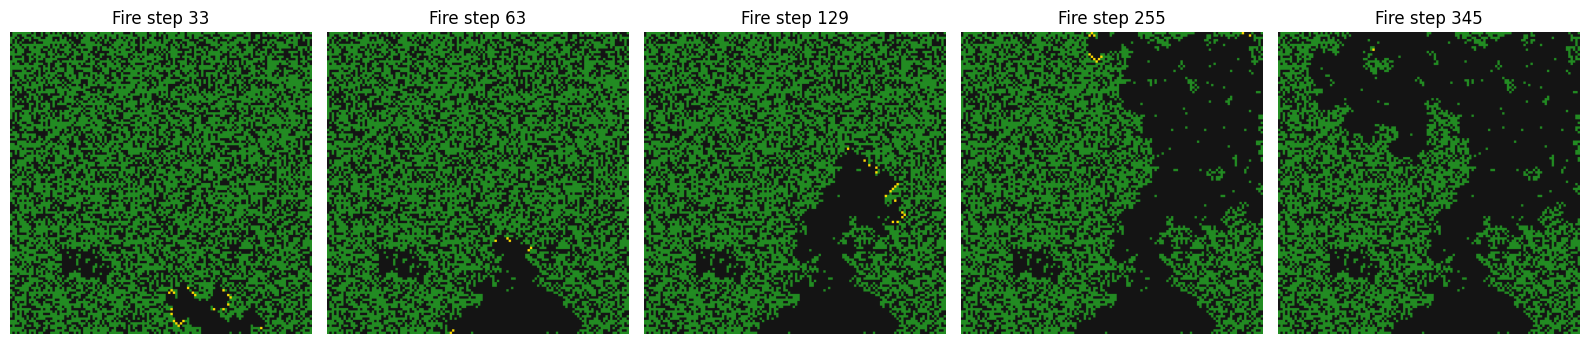

In [1]:
# --- Screenshots
# 5 screenshots at steps ~32, 64, 128, 256 and 345

# limit max_runs to 4, select fires, log_interval = 1, seed = 1138 (or 1??)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgDir = "/Users/mukappa/Documents/Coding/Python VS Code/ML_and_AI_concepts/socsim_automatic_screenshots/"
imageNos = [33, 63, 129, 255, 345]
filenamePrefix = "fire_00004_step_"
paths = [imgDir + filenamePrefix + str(i).zfill(5) + ".png" for i in imageNos]
titles = [str(i) for i in imageNos]

fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for ax, path, title in zip(axes, paths, titles):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Fire step " + title)

plt.tight_layout()
plt.show()



---

## Data-driven SOC signatures

The key question here is: **does the simulated event stream show the “SOC fingerprints”** that motivate later cascade modelling?

Below are the minimal diagnostics I keep because they are interpretable and directly transferable to other domains.

---

### 1) Event size distribution (heavy tails / scale-free-like behaviour)

SOC systems commonly produce **many small events and a few very large events**, leading to a heavy-tailed size distribution. Below we see scale-free probability distributions both for cascade sizes (number of trees burned) and durations (number of time steps until fire extinguishes).

In [3]:
# --- File paths and packages
myFile = "demo_soc_256_50000/soc_fire_sizes_256_50000.txt"
workDir = "/Users/mukappa/Documents/Coding/Python VS Code/ML_and_AI_concepts/"
myPath = str(workDir + myFile)

import numpy as np
import matplotlib.pyplot as plt

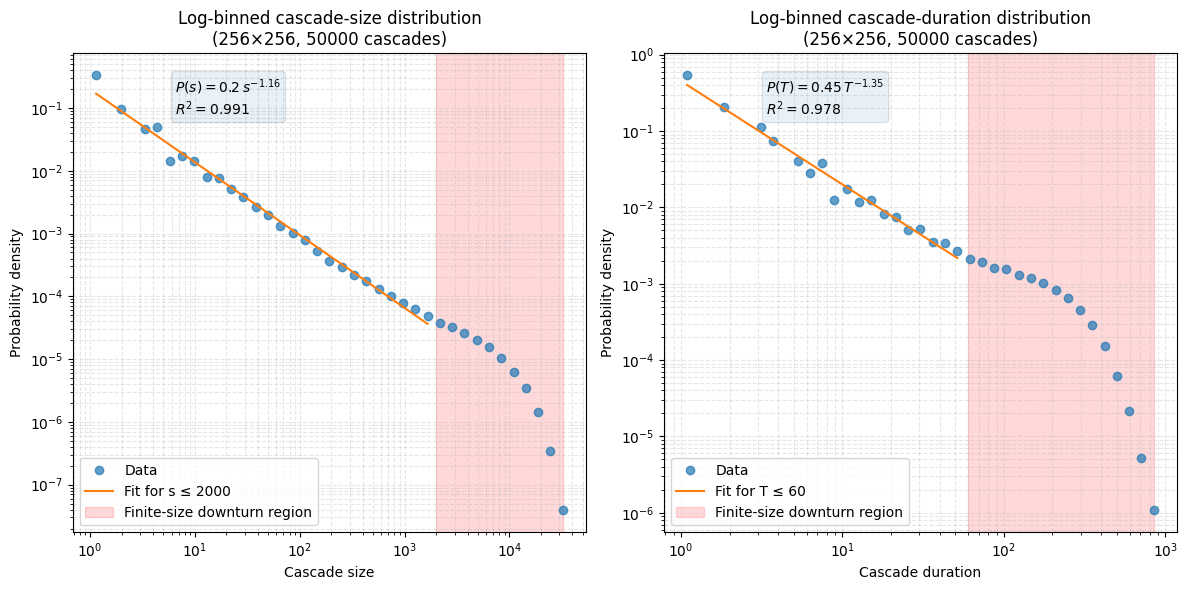

In [7]:
# --- Scale-free (power-law) plots: size and duration side by side ---
# Linear models are plotted and shaded areas highlight effects of finite lattice size

# ---------- Fire sizes file ----------
filename = myPath  # assumes myPath already points to the fire-size file

with open(filename, "r") as f:
    lines = f.read().strip().splitlines()

# --- First line: key=value parameters ---
param_line = lines[0]
param_pairs = param_line.split(",")

params = {}
for pair in param_pairs:
    if "=" in pair:
        k, v = pair.split("=", 1)
        # Try to cast to int/float where possible
        try:
            v_cast = int(v)
        except ValueError:
            try:
                v_cast = float(v)
            except ValueError:
                v_cast = v
        params[k] = v_cast

# --- Remaining lines: fire sizes ---
fire_sizes = np.array([int(x) for x in lines[1:] if x.strip().isdigit()])

# Filter positive sizes
sizes = fire_sizes[fire_sizes > 0]
N_sizes = len(sizes)

min_size = sizes.min()
max_size = sizes.max()

# Choose, say, 30–40 log bins
n_bins = 40
bins_sizes = np.logspace(np.log10(min_size), np.log10(max_size), n_bins)

counts_sizes, edges_sizes = np.histogram(sizes, bins=bins_sizes)

# Normalised counts (probability per bin)
prob_sizes = counts_sizes / N_sizes

# Geometric mean of bin edges as x-coordinate
centers_sizes = np.sqrt(edges_sizes[:-1] * edges_sizes[1:])

# PDF-like (probability per unit fire size)
bin_widths_sizes = edges_sizes[1:] - edges_sizes[:-1]
pdf_sizes = counts_sizes / (N_sizes * bin_widths_sizes)

mask_sizes = pdf_sizes > 0
centers_sizes_plot = centers_sizes[mask_sizes]
pdf_sizes_plot = pdf_sizes[mask_sizes]

# --- Fit settings for sizes ---
x_max_fit_sizes = 2e3  # limit data used for the fit

mask_fit_sizes = (
    (centers_sizes_plot > 0) &
    (pdf_sizes_plot > 0) &
    (centers_sizes_plot <= x_max_fit_sizes)
)

x_fit_sizes = centers_sizes_plot[mask_fit_sizes]
y_fit_sizes = pdf_sizes_plot[mask_fit_sizes]

log_x_sizes = np.log10(x_fit_sizes)
log_y_sizes = np.log10(y_fit_sizes)

m_sizes, b_sizes = np.polyfit(log_x_sizes, log_y_sizes, 1)
log_y_pred_sizes = m_sizes * log_x_sizes + b_sizes

# R^2 in log space
ss_res_sizes = np.sum((log_y_sizes - log_y_pred_sizes)**2)
ss_tot_sizes = np.sum((log_y_sizes - np.mean(log_y_sizes))**2)
r2_sizes = 1 - ss_res_sizes / ss_tot_sizes

# Convert fitted line back to original space
log_x_line_sizes = np.linspace(log_x_sizes.min(), log_x_sizes.max(), 200)
log_y_line_sizes = m_sizes * log_x_line_sizes + b_sizes

x_line_sizes = 10**log_x_line_sizes
y_line_sizes = 10**log_y_line_sizes

A_sizes = 10**b_sizes  # Power-law prefactor: P(s) ≈ A_sizes * s^m_sizes


# ---------- Fire durations file ----------
myFileDur = "demo_soc_256_50000/soc_fire_durations_256_50000.txt"
myPathDur = str(workDir + myFileDur)

dataDur = np.loadtxt(myPathDur, delimiter=",", skiprows=2)

sizes_dur = dataDur[:, 0].astype(int)
durations = dataDur[:, 1].astype(int)

# Filter positive durations
durations = durations[durations > 0]
N_dur = len(durations)

min_duration = durations.min()
max_duration = durations.max()

# Choose, say, 30–40 log bins
bins_dur = np.logspace(np.log10(min_duration), np.log10(max_duration), n_bins)

counts_dur, edges_dur = np.histogram(durations, bins=bins_dur)

# Normalised counts (probability per bin)
prob_dur = counts_dur / N_dur

# Geometric mean of bin edges as x-coordinate
centers_dur = np.sqrt(edges_dur[:-1] * edges_dur[1:])

# PDF-like (probability per unit duration)
bin_widths_dur = edges_dur[1:] - edges_dur[:-1]
pdf_dur = counts_dur / (N_dur * bin_widths_dur)

mask_dur = pdf_dur > 0
centers_dur_plot = centers_dur[mask_dur]
pdf_dur_plot = pdf_dur[mask_dur]

# --- Fit settings for durations ---
x_max_fit_dur = 6e01  # analog to sizes; adjust if you like

mask_fit_dur = (
    (centers_dur_plot > 0) &
    (pdf_dur_plot > 0) &
    (centers_dur_plot <= x_max_fit_dur)
)

x_fit_dur = centers_dur_plot[mask_fit_dur]
y_fit_dur = pdf_dur_plot[mask_fit_dur]

log_x_dur = np.log10(x_fit_dur)
log_y_dur = np.log10(y_fit_dur)

m_dur, b_dur = np.polyfit(log_x_dur, log_y_dur, 1)
log_y_pred_dur = m_dur * log_x_dur + b_dur

# R^2 in log space
ss_res_dur = np.sum((log_y_dur - log_y_pred_dur)**2)
ss_tot_dur = np.sum((log_y_dur - np.mean(log_y_dur))**2)
r2_dur = 1 - ss_res_dur / ss_tot_dur

# Convert fitted line back to original space
log_x_line_dur = np.linspace(log_x_dur.min(), log_x_dur.max(), 200)
log_y_line_dur = m_dur * log_x_line_dur + b_dur

x_line_dur = 10**log_x_line_dur
y_line_dur = 10**log_y_line_dur

A_dur = 10**b_dur  # Power-law prefactor: P(T) ≈ A_dur * T^m_dur


# ---------- Side-by-side plots ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: cascade size distribution ---
ax1.loglog(centers_sizes_plot, pdf_sizes_plot, 'o', alpha=0.7, label="Data")
ax1.loglog(x_line_sizes, y_line_sizes, '-', label=f"Fit for s ≤ {x_max_fit_sizes:.0f}")

# Shade downturn region (beyond fit range)
x_min_shade_sizes = x_max_fit_sizes
x_max_shade_sizes = centers_sizes_plot.max()
ax1.axvspan(x_min_shade_sizes, x_max_shade_sizes, color="red", alpha=0.15,
            label="Finite-size downturn region", zorder=0)

ax1.set_xlabel("Cascade size")
ax1.set_ylabel("Probability density")
ax1.set_title("Log-binned cascade-size distribution\n"
              f"({params['grid_size']}×{params['grid_size']}, {params['max_runs']} cascades)")
ax1.grid(True, which="both", ls="--", alpha=0.3)

eq_text_sizes = (
    r"$P(s) = {:.2g}\,s^{{{:.2f}}}$".format(A_sizes, m_sizes) + "\n" +
    r"$R^2 = {:.3f}$".format(r2_sizes)
)

ax1.text(
    0.2, 0.95, eq_text_sizes,
    transform=ax1.transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", alpha=0.1)
)

ax1.legend()


# --- Right: cascade duration distribution ---
ax2.loglog(centers_dur_plot, pdf_dur_plot, 'o', alpha=0.7, label="Data")
ax2.loglog(x_line_dur, y_line_dur, '-', label=f"Fit for T ≤ {x_max_fit_dur:.0f}")

# Shade downturn region (beyond fit range)
x_min_shade_dur = 6e01
x_max_shade_dur = centers_dur_plot.max()
ax2.axvspan(x_min_shade_dur, x_max_shade_dur, color="red", alpha=0.15,
            label="Finite-size downturn region", zorder=0)

ax2.set_xlabel("Cascade duration")
ax2.set_ylabel("Probability density")
ax2.set_title("Log-binned cascade-duration distribution\n"
              f"({params['grid_size']}×{params['grid_size']}, {params['max_runs']} cascades)")
ax2.grid(True, which="both", ls="--", alpha=0.3)

eq_text_dur = (
    r"$P(T) = {:.2g}\,T^{{{:.2f}}}$".format(A_dur, m_dur) + "\n" +
    r"$R^2 = {:.3f}$".format(r2_dur)
)

ax2.text(
    0.2, 0.95, eq_text_dur,
    transform=ax2.transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", alpha=0.1)
)

ax2.legend()

plt.tight_layout()
plt.show()


**Interpretation:**
- A heavy tail is consistent with SOC-style avalanche dynamics  
- In finite simulations, the tail typically truncates due to grid size and run length  
- The goal is qualitative confirmation of the expected signature, not claiming precise exponents

---

### 2) Activity over time (punctuated equilibrium)

SOC dynamics are often characterised by long quiet periods and intermittent bursts. A simple time series can make this immediately obvious. The line represents the number of trees, increasing slowly in blue (growth) and reducing suddenly in orange (lightning -> fires).

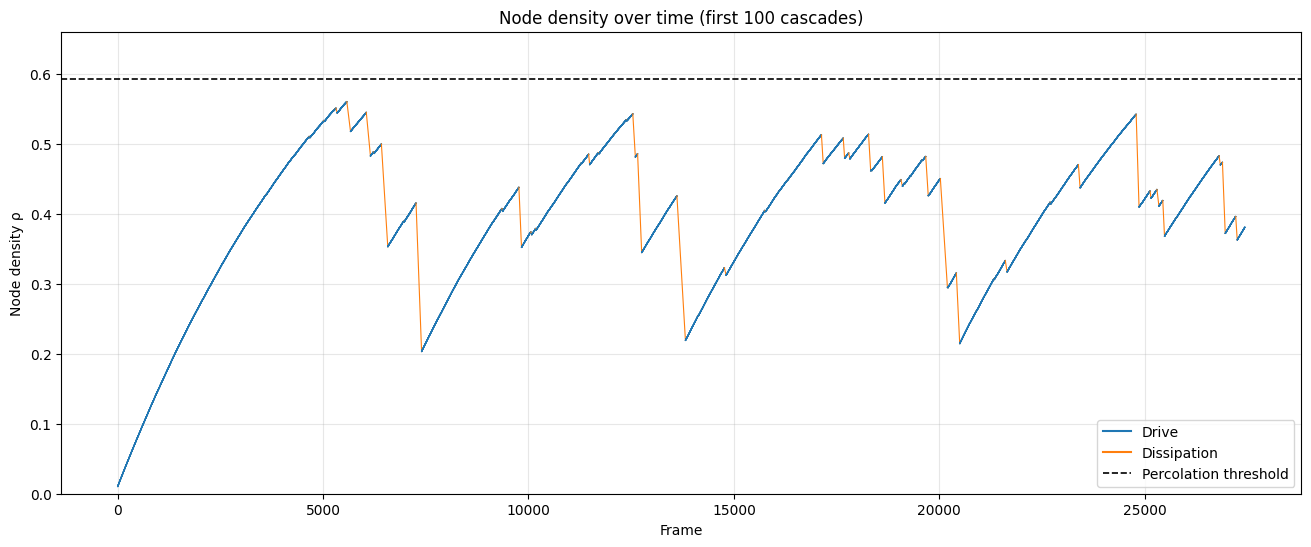

In [ ]:
# --- Slow driving, fast dissipation time series plot
# Drive and release are coloured in blue and orange, respectively
# The percolation threshold for 2D lattice and Von-Neumann neighbours is shown

from matplotlib.lines import Line2D

densityFile = "demo_short_time_series/soc_density_timeseries.txt"
densityPath = workDir + densityFile

dens = np.loadtxt(densityPath, delimiter=",", skiprows=1)
frames = dens[:, 0]
rho = dens[:, 1]

plt.figure(figsize=(16,6))

# Matplotlib default colours
drive_col = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]   # blue
diss_col = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]    # orange

# Plot the time series segment-by-segment
for i in range(len(rho)-1):
    color = drive_col if rho[i+1] >= rho[i] else diss_col
    plt.plot([frames[i], frames[i+1]],
             [rho[i], rho[i+1]],
             color=color,
             lw=0.8)

plt.xlabel("Frame")
plt.ylabel("Node density ρ")
plt.ylim(0, max(rho) + 0.1)
plt.title("Node density over time (first 100 cascades)")
plt.grid(True, alpha=0.3)

# Percolation threshold line
thresh_line = plt.axhline(
    y=0.5927,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="Percolation threshold"
)

# Legend handles
drive_handle = Line2D([0],[0], color=drive_col, lw=1.5, label="Drive")
diss_handle  = Line2D([0],[0], color=diss_col,  lw=1.5, label="Dissipation")

plt.legend(
    handles=[drive_handle, diss_handle, thresh_line],
    loc="lower right"
)

plt.show()



**Interpretation:**
- The time series shows bursts (lightning) separated by calmer phases (forest growth)
- This motivates thinking in terms of **regimes** and **rare high-impact events**

---


### 3) Inter-event timing (burstiness and temporal clustering)

In SOC-style systems, activity often arrives in **bursts rather than at a steady pace**. A barcode (event raster) plot provides a direct visual view of how events are distributed over time.

Each mark represents an event. Dense regions indicate periods of heightened activity, while gaps indicate quieter phases.

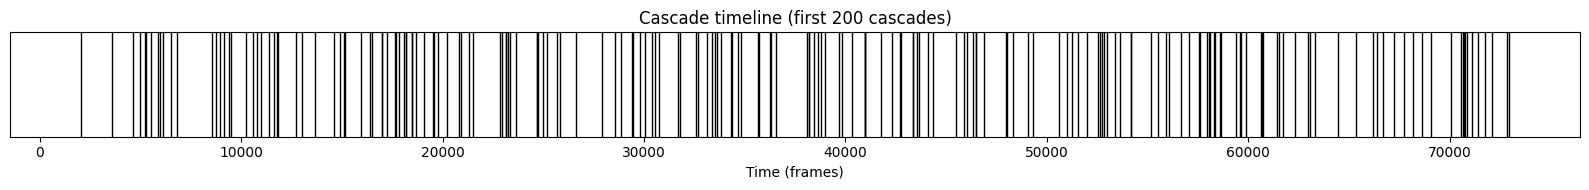

In [ ]:
# --- Barcode plot of intermittency and burstiness

densityFile = "demo_long_time_series/socsim_output_density_timeseries.txt"
densityPath = workDir + densityFile

dens = np.loadtxt(densityPath, delimiter="\t", skiprows=1)
rho = dens[:,1]

rho = np.array(rho)  # ensure numpy array

# 1. Find indices where density drops
drop_indices = np.where(rho[1:] < rho[:-1])[0] + 1

# 2. Cascade start times (one step earlier)
cascade_starts = drop_indices - 1

# 3. Compute waiting times between cascades
waiting_times = np.diff(cascade_starts)

cascade_starts_200 = cascade_starts[:200]
plt.figure(figsize=(16,2))
plt.vlines(cascade_starts_200, ymin=0, ymax=1, color='black', linewidth=1)
plt.ylim(0, 1)
plt.yticks([])
plt.xlabel("Time (frames)")
plt.title("Cascade timeline (first 200 cascades)")
plt.tight_layout()
plt.show()

**Interpretation:**
- Events are not evenly spaced in time; activity clusters into bursts  
- Quiet periods and active periods coexist, consistent with SOC-style dynamics  
- This qualitative structure contrasts with the uniform spacing expected from a simple memoryless process

---


## What this establishes (and what it does not)

**What this establishes**
- Simple local rules (probabilities of tree growth and lightning) can generate **system-level instability** and heavy-tailed event statistics  
- The simulation outputs form an event stream that can be analysed with the same statistical hygiene used in security analytics  
- These SOC signatures provide a concrete foundation for exploring cascades beyond grids

**What this does not claim**
- It is not a claim that real SOC infrastructure follows this model  
- It does not attempt operational prediction or real-world calibration  
- It is a deliberately simplified system used to build correct intuitions and analysis habits

---


## Why this matters for the next step

This toy model is a stepping stone: it provides a controlled environment where SOC signatures are visible and measurable.  

The next stage of the work moves from a grid to **network structures**, where topology, heterogeneity, and node hardening can be explored more directly in ways that align with security-relevant cascade questions.

> **This notebook demonstrates my ability to implement a complex-systems simulator and extract the emergent event statistics that motivate later, more security-relevant network modelling.**

---